Initial shape: (149, 17)

First few rows of the dataset:
     Movie_Name Release_Date(N/LW/Festive)                  Genre-Defind  \
0  Hate Story 2                          N  Thriller / Suspense / Horror   
1         Alone                          N  Thriller / Suspense / Horror   
2           Zid                          N  Thriller / Suspense / Horror   
3          NH10                          N  Thriller / Suspense / Horror   
4  Happy Ending                          N                       Romance   

      Movie_Content Dir_CAT LEAD_ACTOR_CAT  Item_Song(Y/N)  \
0  Prequel / Sequel      LK             LK               1   
1            Masala      LK              B               1   
2            Masala      LK             LK               0   
3            Masala      LK              A               0   
4            Masala      LK              A               0   

  Production_House_CAT Music_Dir_CAT  Box_Office_Collection(in crores)  \
0                    A             B   

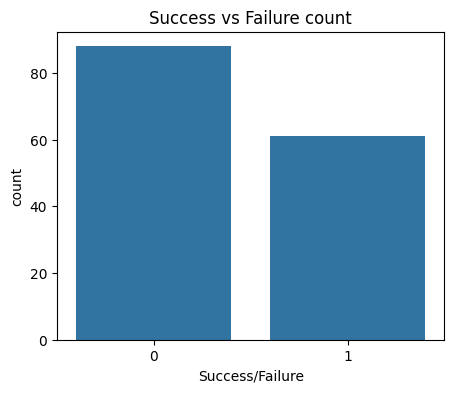

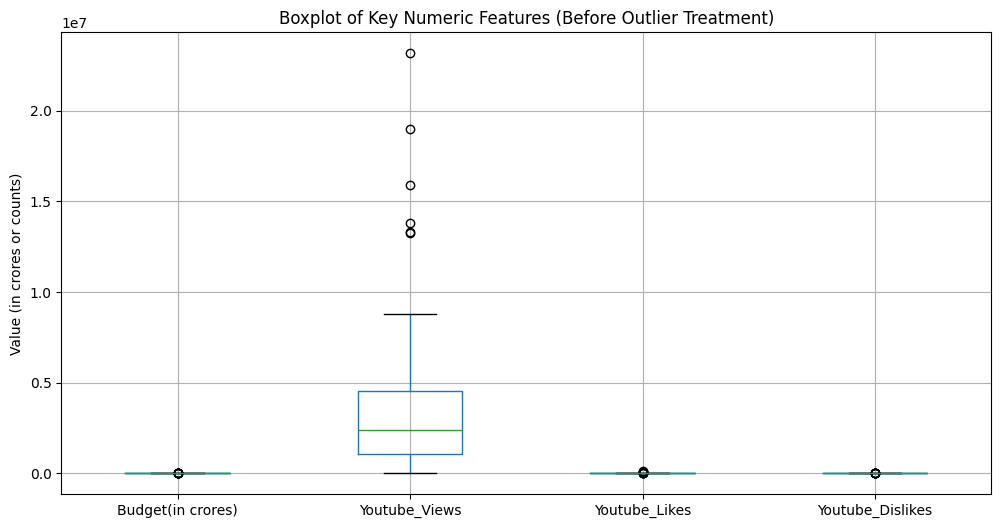

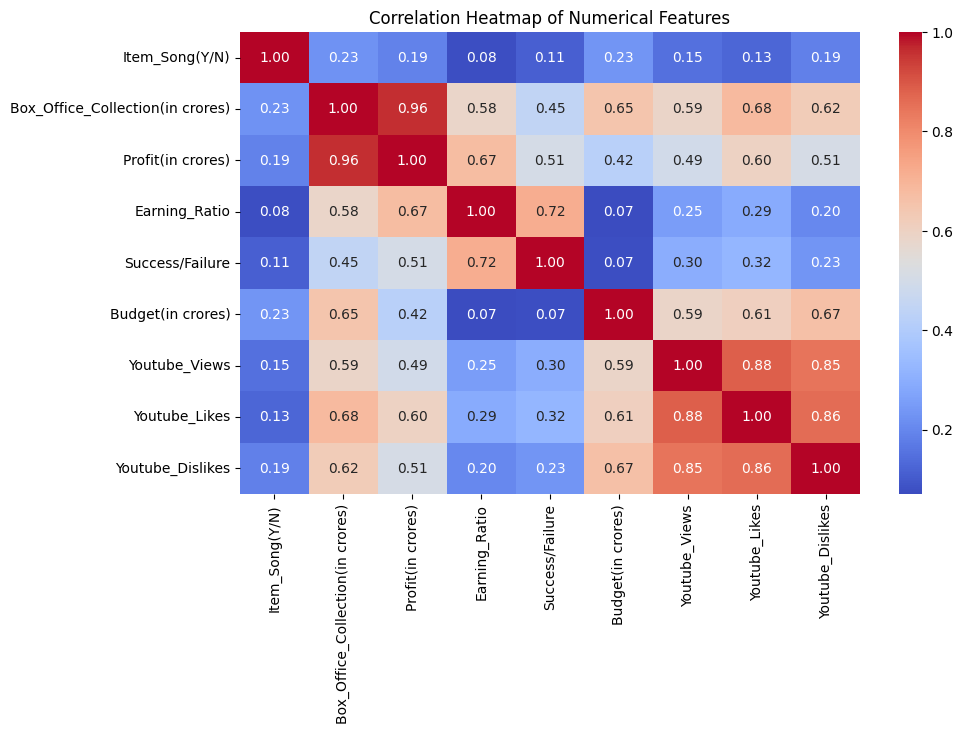

Dropping leakage column: Box_Office_Collection(in crores)
Dropping leakage column: Profit(in crores)
Dropping leakage column: Earning_Ratio

Shape after dropping leakage/ID: (149, 13)

Numeric columns to treat for outliers: ['Item_Song(Y/N)', 'Budget(in crores)', 'Youtube_Views', 'Youtube_Likes', 'Youtube_Dislikes']

Outlier capping applied.

Created feature: Trailer_Engagement

Categorical columns: ['Release_Date(N/LW/Festive)', 'Genre-Defind', 'Movie_Content', 'Dir_CAT', 'LEAD_ACTOR_CAT', 'Production_House_CAT', 'Music_Dir_CAT']
   Release_Date(N/LW/Festive)  Genre-Defind  Movie_Content  Dir_CAT  \
0                           3             4              5        2   
1                           3             4              4        2   
2                           3             4              4        2   
3                           3             4              4        2   
4                           3             3              4        2   

   LEAD_ACTOR_CAT  Item_Song(Y/N)  P

,hidden_layer_sizes,"(50, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,42


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# 1) Load data
# ---------------------------
file_path = '/Users/kamyasarda/Downloads/Bollywood Box Office Success.xlsx'  # Updated path to Downloads folder
df = pd.read_excel(file_path)

# fix target name if misspelled
if 'Success/Faliure' in df.columns:
    df.rename(columns={'Success/Faliure': 'Success/Failure'}, inplace=True)

print("Initial shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())

# ---------------------------
# 2) EDA: info, missing, target balance
# ---------------------------
print("\nData info:")
df.info()

print("\nMissing values per column:")
print(df.isna().sum())

print("\nTarget distribution (counts):")
print(df['Success/Failure'].value_counts())

plt.figure(figsize=(5,4))
sns.countplot(x='Success/Failure', data=df)
plt.title('Success vs Failure count')
plt.show()

# Boxplots to visualize distributions and outliers
num_cols = ['Budget(in crores)', 'Youtube_Views', 'Youtube_Likes', 'Youtube_Dislikes']
plt.figure(figsize=(12,6))
df[num_cols].boxplot()
plt.title("Boxplot of Key Numeric Features (Before Outlier Treatment)")
plt.ylabel("Value (in crores or counts)")
plt.show()

# Correlation heatmap for numeric features
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


# ---------------------------
# 3) Remove redundancy & leakage
# Explanation: For pre-release prediction we must NOT use post-release features.
# We will remove Box_Office_Collection, Profit and Earning_Ratio from model features.
# But we keep a copy of raw data for any descriptive analysis.
# ---------------------------
df_raw = df.copy()  # keep copy for reporting / descriptive stats
leak_cols = ['Box_Office_Collection(in crores)', 'Profit(in crores)', 'Earning_Ratio']
for c in leak_cols:
    if c in df.columns:
        print("Dropping leakage column:", c)
        df = df.drop(columns=[c])

# drop identifier
if 'Movie_Name' in df.columns:
    df = df.drop(columns=['Movie_Name'])

print("\nShape after dropping leakage/ID:", df.shape)

# ---------------------------
# 4) Outlier handling for numeric features (IQR capping)
# ---------------------------
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('Success/Failure')  # keep target out
print("\nNumeric columns to treat for outliers:", num_cols)

# cap outliers using 1.5*IQR (winsorize)
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # cap (winsorize)
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

print("\nOutlier capping applied.")

# ---------------------------
# 5) Simple feature extraction (create trailer engagement metric)
# ---------------------------
# If columns exist, create basic engagement ratio: (likes - dislikes) / views
if set(['Youtube_Views','Youtube_Likes','Youtube_Dislikes']).issubset(df.columns):
    # protect division by zero
    df['Trailer_Engagement'] = (df['Youtube_Likes'] - df['Youtube_Dislikes']) / (df['Youtube_Views'].replace(0, np.nan))
    df['Trailer_Engagement'] = df['Trailer_Engagement'].fillna(0)
    print("\nCreated feature: Trailer_Engagement")

# Also include Budget as-is (if present)
# (We keep features simple and interpretable)

# ---------------------------
# 6) Encode categorical features (LabelEncoder - professor style)
# ---------------------------
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical columns:", cat_cols)

le_map = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_map[col] = le

# Ensure target numeric
if df['Success/Failure'].dtype == 'object':
    df['Success/Failure'] = LabelEncoder().fit_transform(df['Success/Failure'].astype(str))

print(df.head())

# ---------------------------
# 7) Feature selection (mutual information ranking)
# ---------------------------
X_all = df.drop(columns=['Success/Failure'])
y_all = df['Success/Failure']

# compute mutual information for each feature
mi = mutual_info_classif(X_all, y_all, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi, index=X_all.columns).sort_values(ascending=False)
print("\nMutual information feature ranking:")
print(mi_series)

# Choose top k features (e.g., top 8 or fewer if less available)
k = min(8, X_all.shape[1])
top_features = mi_series.index[:k].tolist()
print("\nSelected features:", top_features)

# ---------------------------
# 8) Train/test split (80/20 stratified)
# ---------------------------
X = df[top_features]
y = df['Success/Failure']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)
print("\nTrain target distribution:\n", y_train.value_counts())

# ---------------------------
# 9) 5-fold CV setup (for reporting)
# ---------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mlp= MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

mlp = MLPClassifier(
    hidden_layer_sizes=(50, 25),
    activation='relu',
    solver='adam',
    max_iter=1000,
    verbose=True,   # 👈 THIS
    random_state=42
)
mlp.fit(X_train_scaled, y_train)




